In [1]:
from pyMouSh import MoulinShape, TimeStamps, Qin_constant, Qin_sinusoidal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from matplotlib.patches import ConnectionPatch
from numpy.random import default_rng

from collections import defaultdict
#import pandas as pd
import pickle
import seaborn as sns

sns.set_theme(style="ticks", font_scale=1.25)

secinday = 24*3600

# Calculate arrays for ploting

In [2]:

#temperature profile based of foxx data -- Lauren
tmp = pd.read_csv('Field_Data/temperature_foxx1.csv')
temperature_profile = tmp.temperature.to_numpy()#np.array([ZERO_KELVIN, ZERO_KELVIN])

initial_subglacial_area = 1 
regional_surface_slope = 0.01
channel_length = 25e3
ice_thickness = 500
initial_head = ice_thickness


time_start = 0
time_end = time_start + 6*secinday # 10 days seems enough to equilibrate more the amplitude reduce 
timestep = 30*60 #seconds #timestep is longer to reduce the volume of data
time = TimeStamps(time_start,time_end,timestep)

# how many days to account for the calculation of the min and max of head
idx_nday = -1*48 #days*number of half an hour in a day
idx_nday_test = -2*48


expected_head_amplitude = 50 # or 55 based of visual measurements of the head amplitude in JEME data
original_head_amplitude = 532.44 

#Import head measurement for JEME
jeme_moulin = pd.read_csv('Field_Data/head_jeme.csv')
jeme_moulin = jeme_moulin.dropna()
h_real = jeme_moulin.head_bed.to_numpy()
t_real = jeme_moulin.soy.to_numpy()



### Sensitivity to normalized diurnal meltwater input range NDMIR
~~meltwater input variability~~  

In [4]:
n_run_sim1 = 500 # <------
# create random numbers 
rng1 = default_rng()
rng2 = default_rng() 
rng3 = default_rng()
Qin_mean_run = 1 * rng1.random(n_run_sim1) # <------
Qin_amplitude_run = rng2.random(n_run_sim1) # <------
ice_thickness_run = 300+700 * rng3.random(n_run_sim1)


#initialize variables for loop:
head_amp_sim1 = []
head_amp_sim1_test = []
meltwater_input_sim1 = []
Qin_amp_sim1 = []
Qin_mean_sim1 = []
ice_thickness_sim1 = []

for idx_run in np.arange(n_run_sim1):   
    meltwater_input_sim1 = Qin_sinusoidal(time, Qin_mean_run[idx_run], Qin_amplitude_run[idx_run])         
    moulin = MoulinShape(ice_thickness = ice_thickness_run[idx_run],
                        initial_head = initial_head,
                        initial_subglacial_area = initial_subglacial_area, 
                        channel_length = channel_length,
                        regional_surface_slope = regional_surface_slope,
                        temperature_profile = temperature_profile)
    
    #only take values of amplitude smaller or equal to the mean
    if Qin_mean_run[idx_run]>=2*Qin_amplitude_run[idx_run]:    
               
        for idx,t in enumerate(time) :
            moulin.run1step(time,
                            timestep,
                            meltwater_input_sim1[idx],
                            overflow = True,
                            subglacial_baseflow = 0) 
            
        ##save array for timeseries plot
        #meltwater_input.append(melt_in)   
        #head.append(moulin.dict['head'])

        
        #extract last days for calculating the mean and max
        head_portion = moulin.dict['head'][idx_nday:-1]
        head_portion_test = moulin.dict['head'][idx_nday_test:idx_nday]
        #calculate head amplitude
        head_amp = np.max(head_portion) - np.min(head_portion) #m
        head_amp_test = np.max(head_portion_test) - np.min(head_portion_test)
        if (abs(head_amp - head_amp_test) / head_amp_test)*100 < 2:
            head_amp_sim1.append(head_amp) #m
            head_amp_sim1_test.append(head_amp_test) #m
            #save variable for plot (so that all have the same index)
            Qin_amp_sim1.append(Qin_amplitude_run[idx_run])
            Qin_mean_sim1.append(Qin_mean_run[idx_run])
            ice_thickness_sim1.append(ice_thickness_run[idx_run])
#        else:
#            print('no equilibrium')
#            
#            plt.figure()
#            plt.subplot(3,1,1)
#            plt.plot(time/secinday,meltwater_input_sim1)
#            plt.ylabel('Qin')
#           plt.subplot(3,1,2)
#            plt.plot(time/secinday,moulin.dict['head'],linewidth=3, color='black')
#            plt.plot(time[idx_nday:-1]/secinday,moulin.dict['head'][idx_nday:-1], linestyle='--', color='green')
#            plt.ylabel('head')
#            plt.ylim([0,1000])
#            plt.subplot(3,1,3)
#            plt.plot(time/secinday,moulin.dict['subglacial_radius'],linewidth=3, color='black')
#            plt.plot(time[idx_nday:-1]/secinday,moulin.dict['subglacial_radius'][idx_nday:-1], linestyle='--', color='green')
#            plt.ylabel('radius')
#            plt.savefig('tester\qin_H%d_num%s' %(ice_thickness_run[idx_run],idx_run))

with open('NDMIR.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([head_amp_sim1,Qin_amp_sim1, Qin_mean_sim1, ice_thickness_sim1], f)



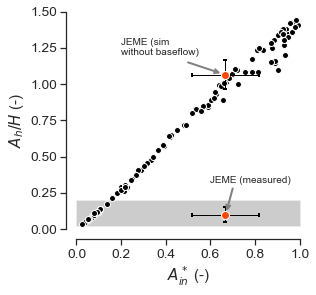

In [175]:
# Getting back the objects:
with open('NDMIR.pkl', 'rb') as f: 
    head_amp_sim1, Qin_amp_sim1, Qin_mean_sim1, ice_thickness_sim1 = pickle.load(f)


fig, ax1 = plt.subplots(figsize=(4,4))

ax1.fill_between([0,1], 10/500,100/500, facecolor = 'black', alpha = 0.2,zorder=0) 
ax1.plot((np.array(Qin_amp_sim1))*2/np.array(Qin_mean_sim1),(np.array(head_amp_sim1)/ice_thickness_sim1),zorder=0,#*100,/expected_head_amplitude
         linestyle='',marker='o',markeredgecolor='white', color='black')
ax1.errorbar(0.2/0.3,original_head_amplitude/500, xerr=0.15, yerr=0.1,fmt='--o',
             markeredgecolor='white', color = 'orangered', zorder=1, elinewidth=1,
             ecolor='black', markersize= 8, capsize=2, capthick=2)
ax1.errorbar(0.2/0.3,expected_head_amplitude/500, xerr=0.15, yerr=0.05,fmt='--o',
             markeredgecolor='white', markersize= 8, color = 'orangered', zorder=1, elinewidth=1,
             ecolor='black', capsize=2, capthick=2)
#ax1.plot(0.2/0.3,original_head_amplitude/500,marker='o',markeredgewidth=2,markeredgecolor='red', color='black')
#ax1.plot(0.2/0.3,expected_head_amplitude/500,marker='o',markeredgewidth=2,markeredgecolor='red', color='black')
ax1.set_xlim([0,1])
ax1.set_ylim([0,1.5])
ax1.set_ylabel('$A_h/H$ (-)')#('$h^{\'}$ (-)')
ax1.set_xlabel('$A_{in}^*$ (-)')#('bf_amplitude/bf_mean')#'Meltwater input variability (-)'
sns.despine(offset=[10,10],trim=True, ax=ax1)

ax1.add_artist(ConnectionPatch((0.5,1.15),(0.2/0.3,original_head_amplitude/500),'data','data', shrinkB=5,
                arrowstyle="->", color='grey', linewidth=2))
ax1.text(0.2,1.2,'JEME (sim \nwithout baseflow)',fontsize=10)

ax1.add_artist(ConnectionPatch((0.7,0.28),(0.2/0.3,0.09),'data','data', shrinkB=5,
                arrowstyle="->", color='grey', linewidth=2))
ax1.text(0.6,0.32,'JEME (measured)',fontsize=10)

plt.savefig('Corr_QIN.pdf',bbox_inches = 'tight')

### Sensitivity to mean baseflow

In [37]:
n_run_sim2 = 200

# create random numbers 
rng1 = default_rng()
rng2 = default_rng() 

bf_mean_run = 5 * rng1.random(n_run_sim2) # <------
ice_thickness_run = 300+700 * rng2.random(n_run_sim2)

#initialize variables for loop:
bf_mean_sim2      = []
ice_thickness_sim2 = []
head_amp_sim2 = []
head_amp_test_sim2 = []


Qin_mean_sim2 = 0.3
Qin_amplitude_sim2 = 0.1
meltwater_input = Qin_sinusoidal(time, Qin_mean_sim2, Qin_amplitude_sim2)

for idx_run in np.arange(n_run_sim2):        
    moulin = MoulinShape(ice_thickness = ice_thickness_run[idx_run],
                          initial_head = initial_head,
                          initial_subglacial_area = initial_subglacial_area, 
                          channel_length = channel_length,
                          regional_surface_slope = regional_surface_slope,
                          temperature_profile = temperature_profile)
        
    for idx,t in enumerate(time) :
        moulin.run1step(time,
                        timestep,
                        meltwater_input[idx],
                        overflow = True,
                        subglacial_baseflow = bf_mean_run[idx_run])         
    #head.append(moulin.dict['head'])
    head_portion = moulin.dict['head'][idx_nday:-1]
    head_portion_test = moulin.dict['head'][idx_nday_test:idx_nday]
    #calculate head amplitude
    head_amp_sim2.append(np.max(head_portion) - np.min(head_portion)) 
    head_amp_test_sim2.append(np.max(head_portion_test) - np.min(head_portion_test))
    #save variables
    bf_mean_sim2.append(bf_mean_run[idx_run])
    ice_thickness_sim2.append(ice_thickness_run[idx_run])
    
with open('MeanBF.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([head_amp_sim2,bf_mean_sim2, ice_thickness_sim2], f)
    


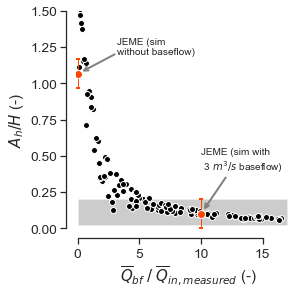

In [170]:
# Getting back the objects:
with open('MeanBF.pkl', 'rb') as f: 
    head_amp_sim2,bf_mean_sim2, ice_thickness_sim2 = pickle.load(f)

fig, ax2 = plt.subplots(figsize=(4,4))

ax2.fill_between([0,17], 10/500,100/500, facecolor = 'black', alpha = 0.2,zorder=0) 

for idx in np.arange(len(bf_mean_sim2)):
    if (abs(head_amp_test_sim2[idx] - head_amp_sim2[idx]) / head_amp_sim2[idx]) * 100 <2:
        ax2.plot(bf_mean_sim2[idx]/Qin_mean_sim2,
                (head_amp_sim2[idx])/500,#*100, 
                 linestyle='',marker='o',markeredgecolor='white', color='black', zorder=1)
        
#ax2.plot(3/0.3,expected_head_amplitude/500,marker='o', markeredgewidth=2,markeredgecolor='red', color='black')
ax2.errorbar(0,original_head_amplitude/500, yerr=0.1,fmt='--o',
             markeredgecolor='white', color = 'orangered', zorder=2, elinewidth=1,
             ecolor='orangered', markersize= 8, capsize=2, capthick=2)
ax2.errorbar(3/0.3,expected_head_amplitude/500,  yerr=0.1,fmt='--o',
             markeredgecolor='white', markersize= 8, color = 'orangered', zorder=2, elinewidth=1,
             ecolor='orangered', capsize=2, capthick=2)
#ax2.plot([0,17],[1,1], linestyle='--', color='darkgrey')
#ax2.set_ylabel('% measured head amplitude (m)')
ax2.set_ylabel('$A_h/H$ (-)')#('$h^{\'}$ (-)')
ax2.set_xlabel('$\overline{Q}_{bf}\; /\; \overline{Q}_{in,measured}$ (-)')#Mean baseflow (Mean $Q_{in}$ equivalent)')#('bf_amplitude/bf_mean')
#Relative mean baseflow \n(mean $Q_{in}$ equivalent)
#ax2.set_ylim([0,300])
#ax.legend()
ax2.set_ylim([0,1.5])
ax2.set_xlim([-0.1,18])
sns.despine(offset=[10,10],trim=True, ax=ax2)

ax2.add_artist(ConnectionPatch((3,1.2),(0,original_head_amplitude/500),'data','data', shrinkB=5,
                arrowstyle="->", color='grey', linewidth=2))
ax2.text(3.2,1.2,'JEME (sim \nwithout baseflow)',fontsize=10)

ax2.add_artist(ConnectionPatch((12,0.35),(3/0.3,expected_head_amplitude/500),'data','data', shrinkB=5,
                arrowstyle="->", color='grey', linewidth=2))
ax2.text(10,0.4,'JEME (sim with \n 3 $m^3/s$ baseflow)',fontsize=10)

plt.savefig('Corr_BF.pdf',bbox_inches = 'tight')


# Sensitivity to lags

In [6]:
lags = np.arange(13)
Qin_mean_sim3 = 0.3
Qin_amplitude_sim3 = 0.1
meltwater_input_sim3 = Qin_sinusoidal(time, Qin_mean_sim3, Qin_amplitude_sim3)

bf_mean_sim3      =  0.6,    
bf_amplitude_sim3 = 0.05, 

#initialize
head_amplitude = np.zeros(len(lags))
head_amp_lag_sim3 = np.zeros(len(lags)) #row,column

#for idx_run in np.arange(len(bf_mean_sim3)):
    
for idx_lag,lag in enumerate(lags):
    baseflow_sim3 = Qin_sinusoidal(time, bf_mean_sim3, bf_amplitude_sim3,shift=lag*3600) #mean,amplitude
    moulin = MoulinShape(ice_thickness = ice_thickness,
                          initial_head = initial_head,
                          initial_subglacial_area = initial_subglacial_area, 
                          channel_length = channel_length,
                          regional_surface_slope = regional_surface_slope,
                          temperature_profile = temperature_profile)

    for idx,t in enumerate(time) :
        moulin.run1step(time,
                        timestep,
                        meltwater_input_sim3[idx],
                        overflow = True,
                        subglacial_baseflow = baseflow_sim3[idx])         
    head_portion = moulin.dict['head'][idx_nday:-1]
    head_amp_lag_sim3[idx_lag] = np.max(head_portion) - np.min(head_portion)#m
#head_amp_lag_sim3 = head_amplitude
        



In [87]:
n_run_sim4 = 200 # <------
# create random numbers 
rng1 = default_rng()
rgn2 = default_rng() 
bf_mean_run = 2 * rng1.random(n_run_sim4) # <------
bf_amplitude_run = 0.2 * rgn2.random(n_run_sim4) # <------


lags_sim4 = [0,3,6,9,12]#np.arange(0,13,2)
Qin_mean_sim4 = 0.3
Qin_amplitude_sim4 = 0.1
meltwater_input_sim4 = Qin_sinusoidal(time, Qin_mean_sim4, Qin_amplitude_sim4)

#initialize
head_amplitude = np.zeros(len(lags_sim4))
head_amplitude_test = np.zeros(len(lags_sim4))
head_amp_lag_sim4 = np.zeros([n_run_sim4,len(lags_sim4)]) #row,column
head_amp_lag_test_sim4 = np.zeros([n_run_sim4,len(lags_sim4)])
bf_mean_sim4 = []
bf_amplitude_sim4 = []

for idx_run in np.arange(n_run_sim4):
    #only take values of amplitude smaller or equal to the mean
    #if bf_mean_run[idx_run]>=2*bf_amplitude_run[idx_run]:  
    print('run = ', idx_run, '/', n_run_sim4 )
    for idx_lag,lag in enumerate(lags_sim4):
        baseflow_sim4 = Qin_sinusoidal(time, bf_mean_run[idx_run], bf_amplitude_run[idx_run],shift=lag*3600) #mean,amplitude
        moulin = MoulinShape(ice_thickness = ice_thickness,
                              initial_head = initial_head,
                              initial_subglacial_area = initial_subglacial_area, 
                              channel_length = channel_length,
                              regional_surface_slope = regional_surface_slope,
                              temperature_profile = temperature_profile)

        for idx,t in enumerate(time) :
            moulin.run1step(time,
                            timestep,
                            meltwater_input_sim4[idx],
                            overflow = True,
                            subglacial_baseflow = baseflow_sim4[idx])         
        #extract last days for calculating the mean and max
        head_portion = moulin.dict['head'][idx_nday:-1]
        head_portion_test = moulin.dict['head'][idx_nday_test:idx_nday]
        #calculate head amplitude
        head_amplitude_test[idx_lag] = np.max(head_portion_test) - np.min(head_portion_test)      
        head_amplitude[idx_lag] = np.max(head_portion) - np.min(head_portion)#m
           
    head_amp_lag_sim4[idx_run] = head_amplitude
    head_amp_lag_test_sim4[idx_run] = head_amplitude_test
    #percent_head_lag[idx_run] = head_amp_lag - head_amp_lag[0]
    bf_amplitude_sim4.append(bf_amplitude_run[idx_run])
    bf_mean_sim4.append(bf_mean_run[idx_run])

with open('lag.pkl', 'wb') as f: 
    pickle.dump([bf_amplitude_sim4,bf_mean_sim4,head_amp_lag_sim4], f)       

run =  0 / 200
run =  1 / 200
run =  2 / 200
run =  3 / 200
run =  4 / 200
run =  5 / 200
run =  6 / 200
run =  7 / 200
run =  8 / 200
run =  9 / 200
run =  10 / 200
run =  11 / 200
run =  12 / 200
run =  13 / 200
run =  14 / 200
run =  15 / 200
run =  16 / 200
run =  17 / 200
run =  18 / 200
run =  19 / 200
run =  20 / 200
run =  21 / 200
run =  22 / 200
run =  23 / 200
run =  24 / 200
run =  25 / 200
run =  26 / 200
run =  27 / 200
run =  28 / 200
run =  29 / 200
run =  30 / 200
run =  31 / 200
run =  32 / 200
run =  33 / 200
run =  34 / 200
run =  35 / 200
run =  36 / 200
run =  37 / 200
run =  38 / 200
run =  39 / 200
run =  40 / 200
run =  41 / 200
run =  42 / 200
run =  43 / 200
run =  44 / 200
run =  45 / 200
run =  46 / 200
run =  47 / 200
run =  48 / 200
run =  49 / 200
run =  50 / 200
run =  51 / 200
run =  52 / 200
run =  53 / 200
run =  54 / 200
run =  55 / 200
run =  56 / 200
run =  57 / 200
run =  58 / 200
run =  59 / 200
run =  60 / 200
run =  61 / 200
run =  62 / 200
ru

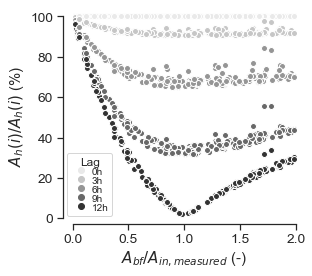

In [171]:
# Getting back the objects:
with open('MeanBF.pkl', 'rb') as f: 
    head_amp_sim2,bf_mean_sim2, ice_thickness_sim2 = pickle.load(f)

#Lag -- timeseries for one baselfow mean

fig, ax4 = plt.subplots(figsize=(4,4))

color = sns.color_palette('Greys', len(lags_sim4))
#color = sns.cubehelix_palette(n_colors=len(lags_sim4))
for idx in np.arange(len(head_amp_lag_sim4)):
        percent_head_lag = (head_amp_lag_sim4[idx]/head_amp_lag_sim4[idx][0]) *100
        ratio_amplitude= (np.array(bf_amplitude_sim4[idx] )/Qin_amplitude_sim4)
        for jdx in np.arange(len(lags_sim4)):
            if (abs(head_amp_lag_test_sim4[idx][jdx] - head_amp_lag_sim4[idx][jdx]) 
                / head_amp_lag_sim4[idx][jdx]) * 100 <5:
                ax4.plot(ratio_amplitude,percent_head_lag[jdx], marker='o', 
                         markeredgecolor='white', color=color[jdx])#, label='lag=0h')
ax4.set_ylabel('$A_{h}(i)/A_{h}(i)$ (%)')
ax4.set_xlabel('$A_{bf}/A_{in,measured}$ (-)')#Amplitude baseflow (Qin amplitude equivalent) (-)')
ax4.set_xlim([0,2])
sns.despine(offset=[10,0],trim=True, ax=ax4)


elements = [Line2D([0], [0],  marker='o', color=color[0], lw=0, label='0h'),
            Line2D([0], [0],  marker='o', color=color[1], lw=0, label='3h'),
            Line2D([0], [0],  marker='o', color=color[2], lw=0, label='6h'),
            Line2D([0], [0],  marker='o', color=color[3], lw=0, label='9h'),
            Line2D([0], [0],  marker='o', color=color[4], lw=0, label='12h')]

#ax4bis.legend(prop={'size': 10}, loc='center left', bbox_to_anchor=(0, 0.35))
ax4.legend(handles=elements, loc=0,  labelspacing=0, handletextpad=0.01,  
           prop={'size': 10}, title='Lag',title_fontsize=12, bbox_to_anchor=(0.2, 0.35))

plt.savefig('Corr_lag.pdf',bbox_inches = 'tight')

# Plot

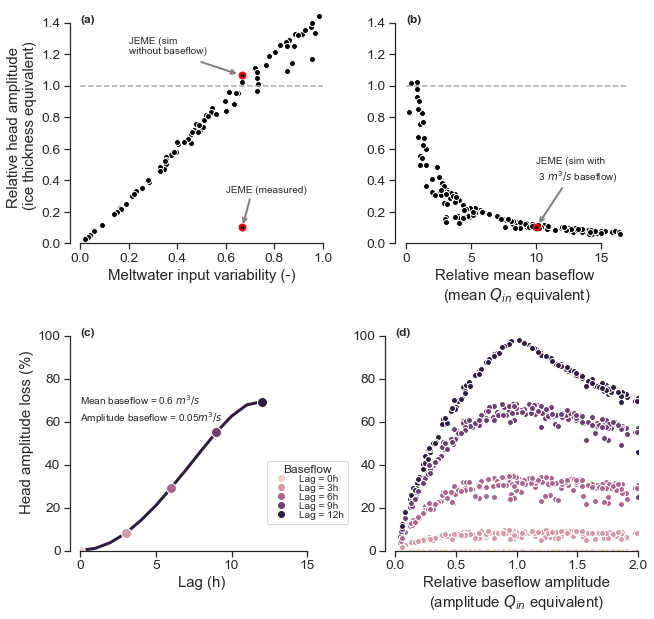

In [22]:

fig = plt.figure(figsize=(10,10))
outer = gridspec.GridSpec(2, 1, hspace = 0.3, height_ratios = [1,1]) 
#gs0 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[0])
gs1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec = outer[0], wspace=0.3)
gs2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec = outer[1], wspace=0.3)

#ax0 = plt.subplot(gs0[0,0])
ax1 = plt.subplot(gs1[0,0])
ax2 = plt.subplot(gs1[0,1], sharey=ax1)
ax3 = plt.subplot(gs2[0,0]) 
ax4 = plt.subplot(gs2[0,1], sharey=ax3)

#example
#time_start = 0
#time_end = time_start + 2*secinday #55
#timestep = 30*60 
#time = TimeStamps(time_start,time_end,timestep)
#head_1 = Qin_sinusoidal(time, Qin_mean_run[idx_run], Qin_amplitude_run[idx_run]) 
#ax0.plot(t_real/secinday,h_real)
#ax0.set_xlim(210,230)
#ax0.set_ylim(0,500)

#Sensitivity to meltwater input
#multiply Qin_amp_sim1 by 2
#ax1.fill_between([-0.5,1.5], 1, 1.5, facecolor = 'darkgrey', alpha = 0.5,zorder=1) 
ax1.plot((np.array(Qin_amp_sim1))*2/np.array(Qin_mean_sim1),(np.array(head_amp_sim1)/ice_thickness_sim1),#*100,/expected_head_amplitude
         linestyle='',marker='o',markeredgecolor='white', color='black')
ax1.plot([0,1],[1,1], linestyle='--', color='darkgrey')
#ax1.plot((np.array(Qin_amp_sim1_800))*2/np.array(Qin_mean_sim1_800),(np.array(head_amp_sim1_800)/800),#*100,/expected_head_amplitude
#         linestyle='',marker='o',markeredgecolor='white', color='green')
ax1.plot(0.2/0.3,original_head_amplitude/500,marker='o',markeredgewidth=2,markeredgecolor='red', color='black')
ax1.plot(0.2/0.3,expected_head_amplitude/500,marker='o',markeredgewidth=2,markeredgecolor='red', color='black')
ax1.set_xlim([0,1])
ax1.set_ylim([0,1.5])
ax1.set_ylabel('Relative head amplitude \n(ice thickness equivalent)')
ax1.set_xlabel('Meltwater input variability (-)')#('bf_amplitude/bf_mean')
sns.despine(offset=[10,0],trim=True, ax=ax1)


#ax2.axhspan(1, 2, facecolor = 'darkgrey', alpha = 0.5,zorder=1) 
for idx in np.arange(len(bf_mean_sim2)):
    if (abs(head_amp_test_sim2[idx] - head_amp_sim2[idx]) / head_amp_sim2[idx]) * 100 <2:
        ax2.plot(bf_mean_sim2[idx]/Qin_mean_sim2,
                (head_amp_sim2[idx])/500,#*100, 
                 linestyle='',marker='o',markeredgecolor='white', color='black')
ax2.plot(3/0.3,expected_head_amplitude/500,marker='o', markeredgewidth=2,markeredgecolor='red', color='black')
ax2.plot([0,17],[1,1], linestyle='--', color='darkgrey')
#ax2.set_ylabel('% measured head amplitude (m)')
ax2.set_xlabel('Relative mean baseflow \n(mean $Q_{in}$ equivalent)')#Mean baseflow (Mean $Q_{in}$ equivalent)')#('bf_amplitude/bf_mean')
#ax2.set_ylim([0,300])
#ax.legend()
sns.despine(offset=[0,0],trim=True, ax=ax2)



palette_lag = sns.cubehelix_palette(n_colors=len(lags))

#Lag -- per baseflow
ax3.plot(lags,100-(head_amp_lag_sim3/head_amp_lag_sim3[0])*100,
         linestyle='-', linewidth=3,
         label='mean = %s $m^3/s$'%bf_mean_sim3, 
         color=palette_lag[-1])          
ax3.set_ylim([0,110])
ax3.set_xlim([0,16])
sns.despine(offset=[10,0],trim=True, ax=ax3)
ax3.set_ylabel('Head amplitude loss (%)')
ax3.set_xlabel('Lag (h)')
ax3.legend(loc=3, prop={'size': 10})

#plots dots
for idx in np.arange(0,len(lags),3):
    ax3.plot(lags[idx],100-(head_amp_lag_sim3[idx]/head_amp_lag_sim3[0])*100,
             linestyle='',marker='o',markeredgecolor='white', markersize=10, color=palette_lag[idx])


#Lag -- timeseries for one baselfow mean
color = sns.cubehelix_palette(n_colors=len(lags_sim4))
for idx in np.arange(len(head_amp_lag_sim4)):
        percent_head_lag = 100-(head_amp_lag_sim4[idx]/head_amp_lag_sim4[idx][0]) *100
        ratio_amplitude= (np.array(bf_amplitude_sim4[idx] )/Qin_amplitude_sim4)
        for jdx in np.arange(len(lags_sim4)):
            if (abs(head_amp_lag_test_sim4[idx][jdx] - head_amp_lag_sim4[idx][jdx]) 
                / head_amp_lag_sim4[idx][jdx]) * 100 <5:
                ax4.plot(ratio_amplitude,percent_head_lag[jdx], marker='o', 
                         markeredgecolor='white', color=color[jdx])#, label='lag=0h')

ax4.set_xlabel('Relative baseflow amplitude\n(amplitude $Q_{in}$ equivalent)')#Amplitude baseflow (Qin amplitude equivalent) (-)')
ax4.set_xlim([0,2])
sns.despine(offset=[10,0],trim=True, ax=ax4)


elements = [Line2D([0], [0],  marker='o', color=color[0], lw=0, label='Lag = 0h'),
            Line2D([0], [0],  marker='o', color=color[1], lw=0, label='Lag = 3h'),
            Line2D([0], [0],  marker='o', color=color[2], lw=0, label='Lag = 6h'),
            Line2D([0], [0],  marker='o', color=color[3], lw=0, label='Lag = 9h'),
            Line2D([0], [0],  marker='o', color=color[4], lw=0, label='Lag = 12h')]

#ax4bis.legend(prop={'size': 10}, loc='center left', bbox_to_anchor=(0, 0.35))
ax3.legend(handles=elements, loc=2, bbox_to_anchor=(0.75, 0.4), labelspacing=0,  
           prop={'size': 10}, title='Baseflow',title_fontsize=12)

ax1.add_artist(ConnectionPatch((0.5,1.15),(0.2/0.3,original_head_amplitude/500),'data','data', shrinkB=5,
                arrowstyle="->", color='grey', linewidth=2))
ax1.text(0.2,1.2,'JEME (sim \nwithout baseflow)',fontsize=10)

ax1.add_artist(ConnectionPatch((0.7,0.28),(0.2/0.3,0.09),'data','data', shrinkB=5,
                arrowstyle="->", color='grey', linewidth=2))
ax1.text(0.6,0.32,'JEME (measured)',fontsize=10)

ax2.add_artist(ConnectionPatch((12,0.35),(3/0.3,expected_head_amplitude/500),'data','data', shrinkB=5,
                arrowstyle="->", color='grey', linewidth=2))
ax2.text(10,0.4,'JEME (sim with \n 3 $m^3/s$ baseflow)',fontsize=10)

#ax3.add_artist(ConnectionPatch((6,45),(7,55),'data','data', shrinkB=5,
#                arrowstyle="->", color='black', linewidth=2))
ax3.text(0,60,'Mean baseflow = 0.6 $m^3/s$\nAmplitude baseflow = 0.05$m^3/s$',fontsize=10)

#letters
ax1.text(0,1.4,'(a)',fontsize=12, weight='bold', bbox=dict(facecolor='white'))
ax2.text(0,1.4,'(b)',fontsize=12, weight='bold', bbox=dict(facecolor='white'))
ax3.text(0,100,'(c)',fontsize=12, weight='bold', bbox=dict(facecolor='white'))
ax4.text(0,100,'(d)',fontsize=12, weight='bold', bbox=dict(facecolor='white'))



plt.savefig('Figure_TC/fig06.pdf',bbox_inches='tight')

In [173]:
np.random.rand(2, 1)

array([[0.6537817 ],
       [0.95086948]])